## Isogeny skips

This notebook contains a simple visualizations for data collected by glitching CSIDH on Chipwhisperer, goal is to check how often do glitches cause a skip of single isogeny.

In [1]:
%run ./init.ipynb # loads datasets, etc.

In [2]:
from csidh import CSIDHDLL

In [3]:
SRC_PATH = "../src"
csidh = CSIDHDLL(SRC_PATH)

[100%] Built target csidh


sh: line 1: cmake: command not found


In [4]:
# Since keyspace is small, we can just precompute everything
keyspace = {}
for e_1 in range(-10, 11):
    for e_2 in range(-10, 11):
        for e_3 in range(-10, 11):
            key = [e_1, e_2, e_3]
            csidh.public = 0xec  # Started at public key corresponding to [-10, 10, -10] = 144 * 409 % 419 = 0xec
            csidh.private = key
            res = csidh.action()
            keyspace[str(key)] = csidh.from_projective(res)

In [5]:
keyspace[str([10, -10, 10])]

0

In [6]:
def skip_isogeny(private, i):
    from copy import copy
    new = copy(private)
    if new[i] == 0:
        return new
    new[i] = new[i] - 1 if new[i] > 0 else new[i] + 1
    return new

# Attack 1
- First attack was randomly glitching whole group action evaluation

## First dataset - key = [10,-10 10]
- Key was [10, -10, 10], we started at public corresponding to [-10, 10, -10], that is 0xec in projective coordinates
- First, check how many of results correspond to one isogeny skip, then try to classify other types of faults

In [7]:
private = [10, -10, 10]
expected_public = 0
df = datasets["dummy"][str(private)]["attack1"]

statistics = {}
statistics["total"] = len(df)
statistics["mutes"] = len(df[df["good/bad/crash"] == "crash"])
statistics["good public"] = len(df[df["good/bad/crash"] == "good"])
statistics["bad public"] = len(df[df["good/bad/crash"] == "bad"])

statistics["skipped 3-isogeny"] = len(df[df["public"] == keyspace[str(skip_isogeny(private, 0))]])
statistics["skipped 5-isogeny"] = len(df[df["public"] == keyspace[str(skip_isogeny(private, 1))]])
statistics["skipped 7-isogeny"] = len(df[df["public"] == keyspace[str(skip_isogeny(private, 2))]])

df = df.dropna()
df["possible"] = df["public"].isin(keyspace.values())
statistics["impossible public"] = len(df[df["possible"] == False])

/tmp/ipykernel_391366/2901128114.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["possible"] = df["public"].isin(keyspace.values())


<Axes: xlabel='time', ylabel='y'>

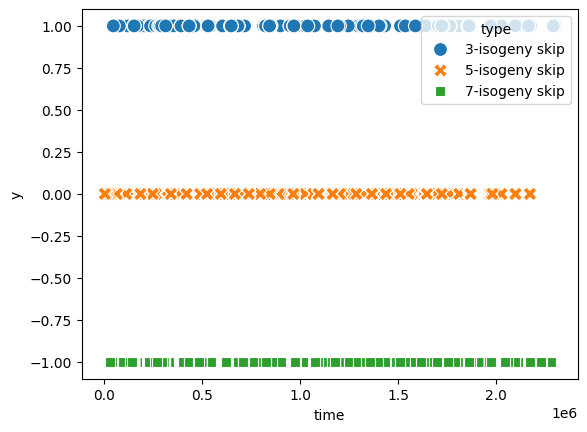

In [8]:
import seaborn as sns


i3skip = df[df["public"] == keyspace[str(skip_isogeny(private, 0))]]
i5skip = df[df["public"] == keyspace[str(skip_isogeny(private, 1))]]
i7skip = df[df["public"] == keyspace[str(skip_isogeny(private, 2))]]

data = {
    'time': list(i3skip["scope.glitch.ext_offset"]) + list(i5skip["scope.glitch.ext_offset"]) + list(i7skip["scope.glitch.ext_offset"]),
    'y': len(i3skip) * [1] + len(i5skip) * [0] + len(i7skip) * [-1],
    'type': len(i3skip) * ['3-isogeny skip'] + len(i5skip) * ['5-isogeny skip'] + len(i7skip) * ['7-isogeny skip']
}

df = pd.DataFrame(data)
sns.scatterplot(data=df, x='time', y='y', hue='type', style='type', s=100)

<Axes: xlabel='time', ylabel='Count'>

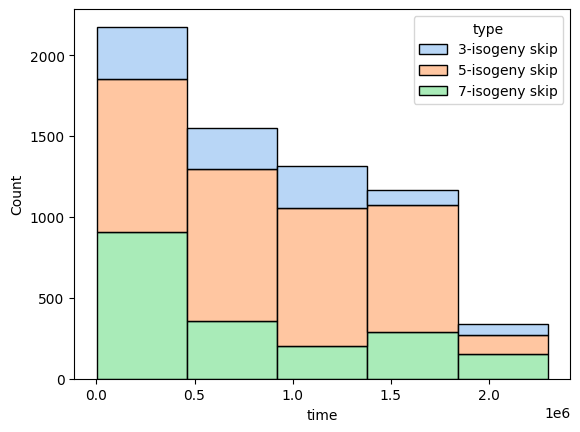

In [9]:
sns.histplot(data=df, x='time', stat="count", multiple="stack"
             , kde=False, palette="pastel", element="bars", hue='type', bins=5)

In [10]:
statistics

{'total': 1035284,
 'mutes': 501708,
 'good public': 430374,
 'bad public': 103202,
 'skipped 3-isogeny': 994,
 'skipped 5-isogeny': 3633,
 'skipped 7-isogeny': 1915,
 'impossible public': 55404}

## Second dataset - key = [10, 0 0]



In [11]:
private = [10, 0, 0]
expected_public = 295
df = datasets["dummy"][str(private)]["attack1"]
df

statistics = {}
statistics["total"] = len(df)
statistics["mutes"] = len(df[df["good/bad/crash"] == "crash"])
statistics["good public"] = len(df[df["good/bad/crash"] == "good"])
statistics["bad public"] = len(df[df["good/bad/crash"] == "bad"])

statistics["skipped 3-isogeny"] = len(df[df["public"] == keyspace[str(skip_isogeny(private, 0))]])
#statistics["skipped 5-isogeny"] = len(df[df["public"] == keyspace[str(skip_isogeny(private, 1))]])
#statistics["skipped 7-isogeny"] = len(df[df["public"] == keyspace[str(skip_isogeny(private, 2))]])

df = df.dropna()
df["possible"] = df["public"].isin(keyspace.values())
statistics["impossible public"] = len(df[df["possible"] == False])

/tmp/ipykernel_391366/241077982.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["possible"] = df["public"].isin(keyspace.values())


In [12]:
statistics

{'total': 2179461,
 'mutes': 909125,
 'good public': 1162250,
 'bad public': 108085,
 'skipped 3-isogeny': 1864,
 'impossible public': 56644}

<Axes: xlabel='time', ylabel='y'>

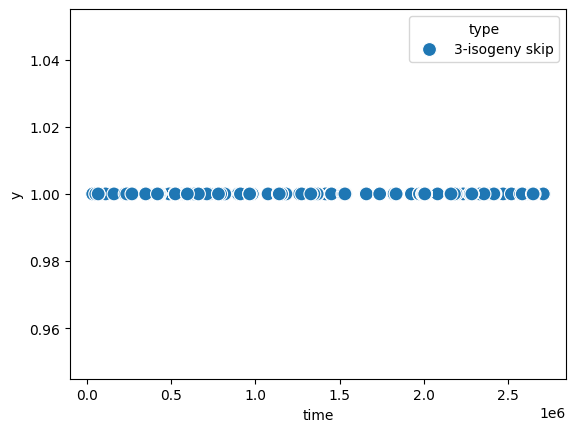

In [13]:
import seaborn as sns


i3skip = df[df["public"] == keyspace[str(skip_isogeny(private, 0))]]
#i5skip = df[df["public"] == keyspace[str(skip_isogeny(private, 1))]]
#i7skip = df[df["public"] == keyspace[str(skip_isogeny(private, 2))]]

data = {
    'time': list(i3skip["scope.glitch.ext_offset"]), #+ list(i5skip["scope.glitch.ext_offset"]) + list(i7skip["scope.glitch.ext_offset"]),
    'y': len(i3skip) * [1], #+ len(i5skip) * [0] + len(i7skip) * [-1],
    'type': len(i3skip) * ['3-isogeny skip'],# + len(i5skip) * ['5-isogeny skip'] + len(i7skip) * ['7-isogeny skip']
}

df = pd.DataFrame(data)
sns.scatterplot(data=df, x='time', y='y', hue='type', style='type', s=100)

<Axes: xlabel='time', ylabel='Count'>

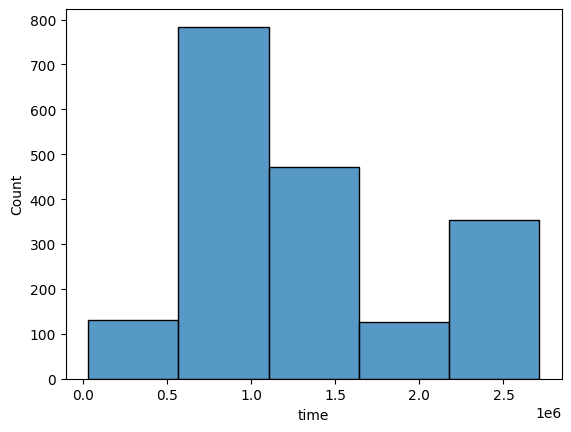

In [14]:
sns.histplot(data=df, x='time', bins=5)

# Attack 2

In [15]:
private = [10, -10, 10]
df = datasets["dummy"][str(private)]["attack2"]
df

statistics = {}
statistics["total"] = len(df)
statistics["mutes"] = len(df[df["good/bad/crash"] == "crash"])
statistics["good public"] = len(df[df["good/bad/crash"] == "good"])
statistics["bad public"] = len(df[df["good/bad/crash"] == "bad"])

statistics["skipped 3-isogeny"] = len(df[df["public"] == keyspace[str(skip_isogeny(private, 0))]])
statistics["skipped 5-isogeny"] = len(df[df["public"] == keyspace[str(skip_isogeny(private, 1))]])
statistics["skipped 7-isogeny"] = len(df[df["public"] == keyspace[str(skip_isogeny(private, 2))]])

df = df.dropna()
df["possible"] = df["public"].isin(keyspace.values())
statistics["impossible public"] = len(df[df["possible"] == False])

/tmp/ipykernel_391366/628272163.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["possible"] = df["public"].isin(keyspace.values())


In [16]:
statistics

{'total': 368701,
 'mutes': 151107,
 'good public': 173201,
 'bad public': 44393,
 'skipped 3-isogeny': 431,
 'skipped 5-isogeny': 1139,
 'skipped 7-isogeny': 1958,
 'impossible public': 17851}

In [17]:
private = [10, -10, 0]
df = datasets["dummy"][str(private)]["attack2"]
df

statistics = {}
statistics["total"] = len(df)
statistics["mutes"] = len(df[df["good/bad/crash"] == "crash"])
statistics["good public"] = len(df[df["good/bad/crash"] == "good"])
statistics["bad public"] = len(df[df["good/bad/crash"] == "bad"])

statistics["skipped 3-isogeny"] = len(df[df["public"] == keyspace[str(skip_isogeny(private, 0))]])
statistics["skipped 5-isogeny"] = len(df[df["public"] == keyspace[str(skip_isogeny(private, 1))]])
#statistics["skipped 7-isogeny"] = len(df[df["public"] == keyspace[str(skip_isogeny(private, 2))]])

df = df.dropna()
df["possible"] = df["public"].isin(keyspace.values())
statistics["impossible public"] = len(df[df["possible"] == False])

/tmp/ipykernel_391366/3781355314.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["possible"] = df["public"].isin(keyspace.values())


In [18]:
statistics

{'total': 29367,
 'mutes': 11298,
 'good public': 16135,
 'bad public': 1934,
 'skipped 3-isogeny': 40,
 'skipped 5-isogeny': 30,
 'impossible public': 806}